Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/24
----------
train Loss: 0.6386 Acc: 0.7600
val Loss: 0.4938 Acc: 0.8800
Epoch 1/24
----------
train Loss: 0.4691 Acc: 0.9520
val Loss: 0.9407 Acc: 0.9200
Epoch 2/24
----------
train Loss: 0.7857 Acc: 0.9520
val Loss: 1.8385 Acc: 0.9000
Epoch 3/24
----------
train Loss: 0.3681 Acc: 0.9720
val Loss: 1.0267 Acc: 0.9400
Epoch 4/24
----------
train Loss: 0.3798 Acc: 0.9800
val Loss: 0.2651 Acc: 0.9400
Epoch 5/24
----------
train Loss: 0.2940 Acc: 0.9880
val Loss: 0.0983 Acc: 0.9800
Epoch 6/24
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 0.0937 Acc: 0.9800
Epoch 7/24
----------
train Loss: 0.2568 Acc: 0.9800
val Loss: 2.1273 Acc: 0.9200
Epoch 8/24
----------
train Loss: 0.1451 Acc: 0.9840
val Loss: 0.1230 Acc: 0.9800
Epoch 9/24
----------
train Loss: 0.0726 Acc: 0.9960
val Loss: 0.0097 Acc: 1.0000
Epoch 10/24
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 0.0000 Acc: 1.0000
Epoch 11/24
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 0.0000 Acc: 1.0000
Epoch 12/24
--

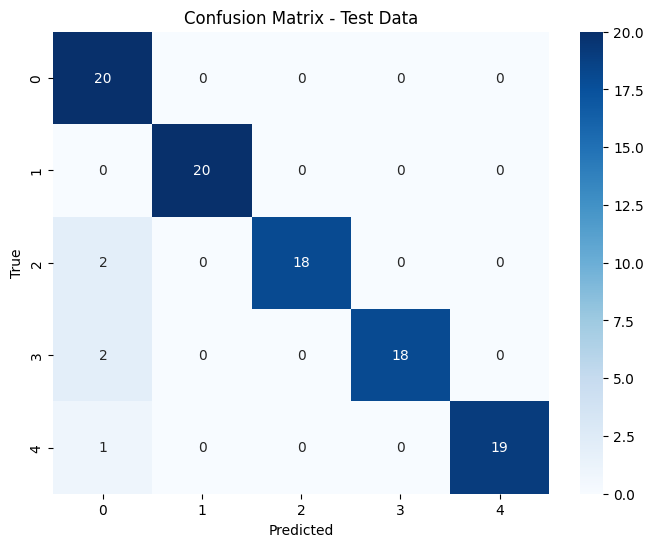

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define transformations for the training, validation, and test sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Set the path to your dataset stored in Google Drive
data_dir = '/content/drive/MyDrive/Data'  # Replace with your dataset directory

# Load the datasets
image_datasets = {
    'train': datasets.ImageFolder(f'{data_dir}/train', data_transforms['train']),
    'val': datasets.ImageFolder(f'{data_dir}/val', data_transforms['val']),
    'test': datasets.ImageFolder(f'{data_dir}/test', data_transforms['test']),
}

# Create data loaders
batch_size = 32
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False),
    'test': DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False)
}

# Load the pre-trained VGG19 model
model = models.vgg19(pretrained=True)

# Modify the classifier layer to have 5 output nodes (for 5 classes)
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 5)

# Move the model to the GPU (if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.classifier.parameters(), lr=0.001,weight_decay=1e-5)
optimizer = optim.SGD(model.classifier.parameters(), lr=0.01, momentum=0.9)
# Training function
def train_model(model, criterion, optimizer, num_epochs=25):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    print(f'Best val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model = train_model(model, criterion, optimizer, num_epochs=15)

# Test the model
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_preds, all_labels

# Evaluate on test data
test_preds, test_labels = evaluate_model(model, dataloaders['test'])

# Calculate accuracy
test_acc = accuracy_score(test_labels, test_preds)
print(f'Test Accuracy: {test_acc:.4f}')

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test Data")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [5]:
# Experiment with different hyperparameters
optimizer = optim.SGD(model.classifier.parameters(), lr=0.01, momentum=0.9)  # Adjust learning rate and optimizer
model = train_model(model, criterion, optimizer, num_epochs=15)


Epoch 0/14
----------
train Loss: 487.3359 Acc: 0.8040
val Loss: 526.6104 Acc: 0.8600
Epoch 1/14
----------
train Loss: 172453239.6774 Acc: 0.5280
val Loss: 2463883059.2000 Acc: 0.2000
Epoch 2/14
----------
train Loss: nan Acc: 0.2080
val Loss: nan Acc: 0.2000
Epoch 3/14
----------
train Loss: nan Acc: 0.2000
val Loss: nan Acc: 0.2000
Epoch 4/14
----------
train Loss: nan Acc: 0.2000
val Loss: nan Acc: 0.2000
Epoch 5/14
----------
train Loss: nan Acc: 0.2000
val Loss: nan Acc: 0.2000
Epoch 6/14
----------
train Loss: nan Acc: 0.2000
val Loss: nan Acc: 0.2000
Epoch 7/14
----------
train Loss: nan Acc: 0.2000
val Loss: nan Acc: 0.2000
Epoch 8/14
----------
train Loss: nan Acc: 0.2000
val Loss: nan Acc: 0.2000
Epoch 9/14
----------
train Loss: nan Acc: 0.2000
val Loss: nan Acc: 0.2000
Epoch 10/14
----------
train Loss: nan Acc: 0.2000
val Loss: nan Acc: 0.2000
Epoch 11/14
----------
train Loss: nan Acc: 0.2000
val Loss: nan Acc: 0.2000
Epoch 12/14
----------
train Loss: nan Acc: 0.2000
va

Processing image for class: 2


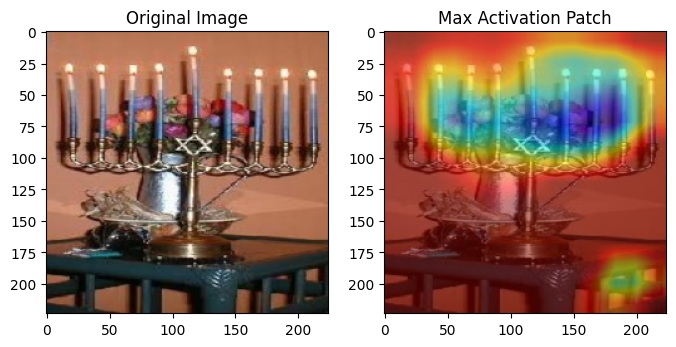

Processing image for class: 3


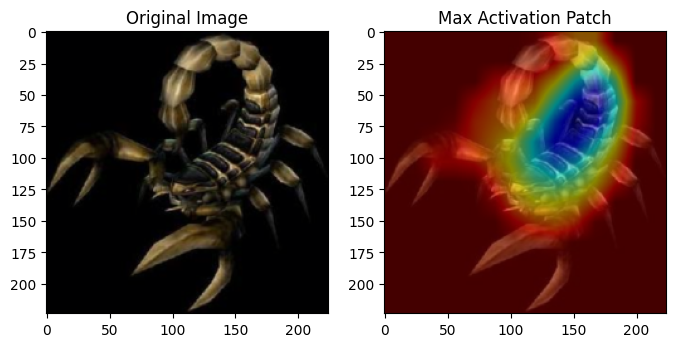

Processing image for class: 1


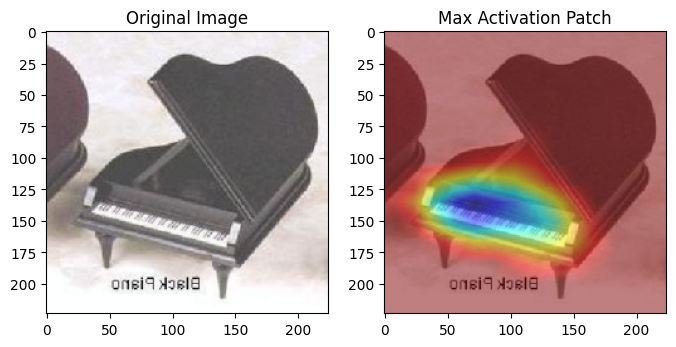

Processing image for class: 0


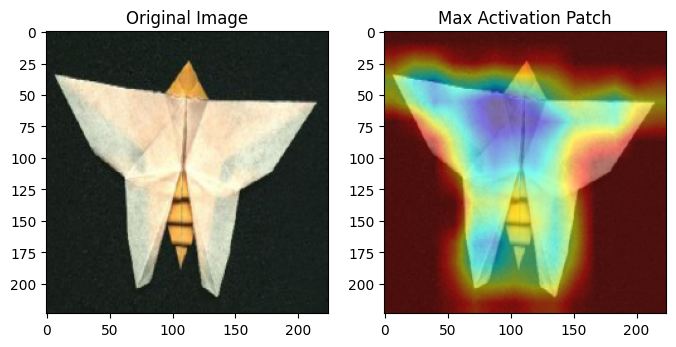

Processing image for class: 4


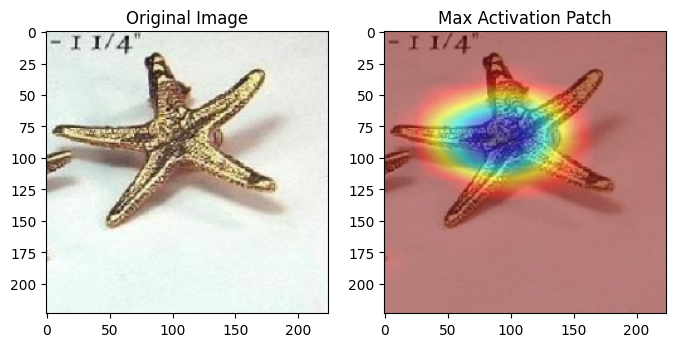

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader

# Hook to store the feature map from the last convolutional layer
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Load VGG19 pre-trained model
model = models.vgg19(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 5)  # Modify for 5 output classes

# Register the hook for the last convolutional layer (layer 'features.35')
layer_name = 'features.35'  # VGG19's last convolutional layer
model.features[35].register_forward_hook(get_activation(layer_name))

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()  # Set model to evaluation mode

# Define image preprocessing transformation
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define the dataset directory and load the dataset
data_dir = '/content/drive/MyDrive/Data'  # Path to your dataset
dataset = datasets.ImageFolder(f'{data_dir}/train', transform=preprocess)

# DataLoader to fetch the images
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Select one image from each class
def select_images_per_class(dataloader, num_classes=5):
    class_images = {}
    for inputs, labels in dataloader:
        label = labels.item()
        if label not in class_images:  # Only take one image per class
            class_images[label] = inputs
        if len(class_images) == num_classes:  # Stop when all classes are covered
            break
    return class_images

# Forward pass the image through the model to capture the activation map
def get_max_activated_patch(model, img_tensor):
    img_tensor = img_tensor.to(device)
    _ = model(img_tensor)  # Forward pass through the network

    # Get the feature map from the last convolutional layer
    feature_map = activation[layer_name].cpu().numpy()[0]

    # Get the feature map with the highest activation (max neuron)
    max_activation_index = np.argmax(feature_map.mean(axis=(1, 2)))  # Neuron with max activation
    max_activated_feature_map = feature_map[max_activation_index]

    # Rescale the activation map to match the input image size
    max_activated_feature_map_resized = cv2.resize(max_activated_feature_map, (224, 224))

    return max_activated_feature_map_resized

# Visualize the image with heatmap highlighting the patch causing the neuron to fire
def visualize_activation(img, activation_map):
    img = img.permute(1, 2, 0).numpy()  # Convert from tensor to NumPy array
    img = np.clip(img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)

    # Normalize the activation map for visualization
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())

    # Convert the activation map to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * activation_map), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    # Overlay the heatmap on the original image
    overlayed_image = heatmap + np.float32(img)
    overlayed_image = overlayed_image / np.max(overlayed_image)

    # Plot the original image and the overlayed heatmap
    plt.figure(figsize=(8, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(np.uint8(255 * overlayed_image))
    plt.title("Max Activation Patch")
    plt.show()

# Main function to process and visualize activations for one image per class
def main():
    class_images = select_images_per_class(dataloader)  # Get one image per class

    for class_id, img_tensor in class_images.items():
        print(f"Processing image for class: {class_id}")
        max_activated_patch = get_max_activated_patch(model, img_tensor)
        visualize_activation(img_tensor[0], max_activated_patch)

main()
